In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.metrics import mean_squared_error

from warnings import filterwarnings
filterwarnings('ignore')

np.random.seed(42)


# Overview:
1. Toy machine-learning model (ML) example
2. Minimal MLflow example
3. Log individual ML model w/ MLflow
4. Automatically run set of ML models, later check w/ MLflow
5. Load trained models from MLflow archive

# 1. Setting up toy machine-learning example

## Loading and pre-processing dataset

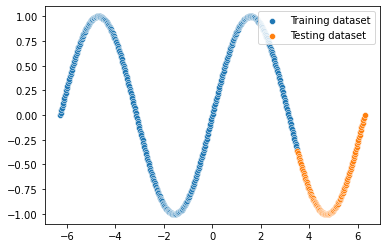

In [52]:
# Define dataset
def get_dataset(t=3.5):
    X = np.linspace(-2*np.pi, 2*np.pi, 500)
    y = np.sin(X)
    
    X_dataset, y_dataset = X[X<t], y[X<t]
    X_test, y_test = X[X>t], y[X>t]
    
    return X_dataset, y_dataset, X_test, y_test

X_dataset, y_dataset, X_test, y_test = get_dataset()

sns.scatterplot(x=X_dataset, y=y_dataset)
sns.scatterplot(x=X_test, y=y_test)
plt.legend(["Training dataset", "Testing dataset"], loc="upper right")

Text(0.5, 1.0, 'Validation dataset')

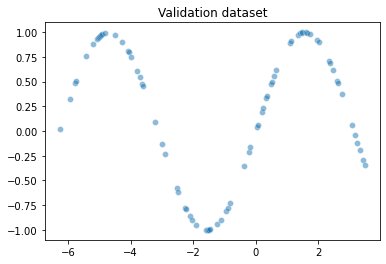

In [53]:
def preprocess_dataset(X_dataset, y_dataset, train_part=0.80, verbose=False):
    # Assign training and validation datasets
    dataset_indices = np.array(range(len(X_dataset)))

    train_indices = np.random.choice(dataset_indices, int(len(dataset_indices)*train_part), replace=False)
    valid_indices = dataset_indices[~np.isin(dataset_indices, train_indices)]

    X_train, y_train = X_dataset[train_indices], y_dataset[train_indices]
    X_val, y_val = X_dataset[valid_indices], y_dataset[valid_indices]

    X_train = X_train.reshape(-1, 1)
    X_val = X_val.reshape(-1, 1)

    if verbose: print("Lengths: X_train %s, y_train %s, X_val %s, y_val %s" % (len(X_train), len(y_train), len(X_val), len(y_val)))

    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = preprocess_dataset(X_dataset, y_dataset, train_part=0.80)

sns.scatterplot(x=X_val[:, 0], y=y_val, alpha=0.50)
plt.title("Validation dataset")

## Training and evaluating model

In [54]:
from sklearn.metrics import mean_squared_error
def plot_performance(x, y, y_hat, color="red"):
    x = x[:, 0]
    
    # Plot validation set performance
    fig = sns.scatterplot(x=x, y=y, color="gray")
    fig = sns.scatterplot(x=x, y=y_hat, color=color)

    # Figure annotation
    plt.legend(["True scores", "Predicted scores"])
    plt.xlabel("Input")
    plt.ylabel("Output")

    # Title
    str_loss = str(np.round(mean_squared_error(y, y_hat), 4))
    title = "Validation set predictions,\nMSE loss = " + str_loss
    plt.title(title)
    
    plt.savefig("performance.pdf")

Epoch 0, train_loss 0.663, val_loss 0.691
Epoch 1, train_loss 0.528, val_loss 0.56
Epoch 2, train_loss 0.452, val_loss 0.467
Epoch 3, train_loss 0.422, val_loss 0.445
Epoch 4, train_loss 0.401, val_loss 0.434
Epoch 5, train_loss 0.375, val_loss 0.395
Epoch 6, train_loss 0.352, val_loss 0.376
Epoch 7, train_loss 0.283, val_loss 0.315
Epoch 8, train_loss 0.275, val_loss 0.301
Epoch 9, train_loss 0.256, val_loss 0.283
Epoch 10, train_loss 0.249, val_loss 0.275
Epoch 11, train_loss 0.219, val_loss 0.241
Epoch 12, train_loss 0.176, val_loss 0.202
Epoch 13, train_loss 0.174, val_loss 0.199
Epoch 14, train_loss 0.169, val_loss 0.194
Epoch 15, train_loss 0.166, val_loss 0.192
Epoch 16, train_loss 0.164, val_loss 0.19
Epoch 17, train_loss 0.16, val_loss 0.185
Epoch 18, train_loss 0.158, val_loss 0.183
Epoch 19, train_loss 0.154, val_loss 0.179


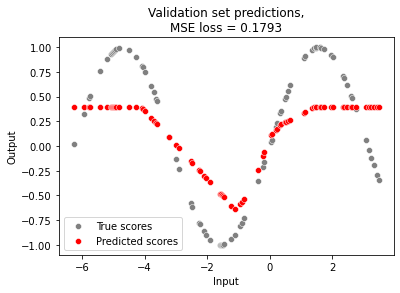

In [58]:
from sklearn.neural_network import MLPRegressor
# Activations: relu, tanh, logistic, identity
# Solver: lbfgs, adam, sgd
# hidden_layer_sizes: list of length layers, integer for nodes per layer
# alpha: L2-penalty, regularization
model = MLPRegressor(max_iter=1, warm_start=True, learning_rate_init=0.001,
                     activation='relu',
                     hidden_layer_sizes=[6,6,6],
                     solver = "lbfgs"
                     )

# Train and evaluate on validation set
total_epochs = 20
for epoch in range(0, total_epochs):
    # Fit model
    model.fit(X_train, y_train)

    # Get predictions
    train_preds = model.predict(X_train)
    train_loss = np.round(mean_squared_error(train_preds, y_train), 3)
    
    val_preds = model.predict(X_val)
    val_loss = np.round(mean_squared_error(val_preds, y_val), 3)
    
    print("Epoch %s, train_loss %s, val_loss %s" % (epoch, train_loss, val_loss))
    
plot_performance(X_val, y_val, val_preds)    

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
def calculate_performance(y_true, y_pred):
    mse = np.round(mean_squared_error(y_true, y_pred), 4)
    mae = np.round(mean_absolute_error(y_true, y_pred), 4)
    sr = np.round(spearmanr(y_true, y_pred)[0], 4)
    
    return {"MSE":mse, "MAE":mae, "Spearmanr":sr}

calculate_performance(val_preds, y_val)

{'MSE': 0.1793, 'MAE': 0.3747, 'Spearmanr': 0.7621}

# 2. Minimal example of MLflow

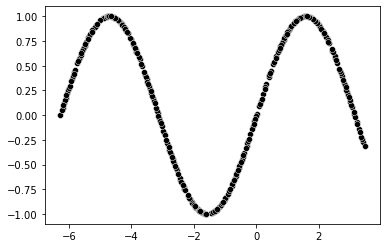

In [61]:
mlflow.set_experiment(experiment_name="Minimal_example")
with mlflow.start_run(run_name="Test"):
    # Log hyperparameters / other info
    mlflow.log_param("A", 1)
    mlflow.log_param("B", 2)
    
    # Log values multiple times
    for i in range(10):
        mlflow.log_metric("C", i, step=i)
        
    # Log images or files
    sns.scatterplot(X_train.reshape(-1), y_train, color="black")
    plt.savefig("minimal_example.pdf")
    mlflow.log_artifact("minimal_example.pdf")
    

# 3. Logging our machine-learning experiment with MLflow

Tasks:
1. Put training and evaluation inside one function
2. Add MLflow logging of hyperparameters, losses, final performance metrics and plot

In [62]:
import mlflow
from sklearn.neural_network import MLPRegressor
def train_eval_model(X_train, y_train, X_val, y_val,
                     activation="relu", solver="lbfgs", hidden_layer_sizes=1,
                    lr=0.001, epochs=20, verbose=False):
    
    model = MLPRegressor(max_iter=1, warm_start=True, learning_rate_init=lr,
                         activation=activation,
                         solver = solver,
                         hidden_layer_sizes=hidden_layer_sizes
                         )

    # Train and evaluate on validation set
    total_epochs = epochs
    for epoch in range(0, total_epochs):
        # Fit model
        model.fit(X_train, y_train)
        
        # Log trained sklearn model
        mlflow.sklearn.log_model(model, "model")

        # Get predictions and losses
        train_preds = model.predict(X_train)
        train_loss = np.round(mean_squared_error(train_preds, y_train), 3)
        val_preds = model.predict(X_val)
        val_loss = np.round(mean_squared_error(val_preds, y_val), 3)
        
        # Log losses
        mlflow.log_metric("Train_loss", train_loss, step=epoch)
        mlflow.log_metric("Val_loss", val_loss, step=epoch)

        if verbose: print("Epoch %s, train_loss %s, val_loss %s" % (epoch, train_loss, val_loss))
        
    return(val_preds, val_loss)

Running MLFlow:
- Run your script including MLflow code -> creates mlflow folder
- run mlflow ui from script directory
- open link in browser, e.g. http://127.0.0.1:5000/

{'MSE': 0.0839, 'MAE': 0.2286, 'Spearmanr': 0.8293}
Done


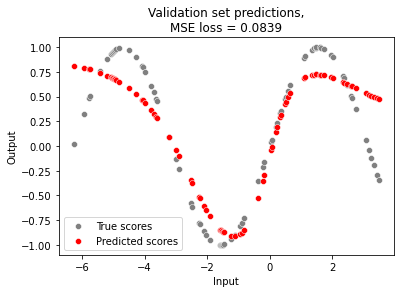

In [64]:
mlflow.set_experiment(experiment_name="MLP_Manual")
with mlflow.start_run(run_name="MLPRegressor"):
    mlflow.log_param("Epochs", 20)
    
    # Activations: relu, tanh, logistic, identity
    # Solver: lbfgs, adam, sgd
    # hidden_layer_sizes: list of length layers, integer for nodes per layer
    # alpha: L2-penalty, regularization
    val_preds, val_loss = train_eval_model(X_train, y_train, X_val, y_val,
                                          activation="tanh", solver="lbfgs",
                                          hidden_layer_sizes=[6,6,6], lr=0.01)
    
    # Log performance values
    performance_dict = calculate_performance(y_val, val_preds)
    mlflow.log_metric("MeanSquaredError", performance_dict["MSE"])
    mlflow.log_metric("MeanAbsoluteError", performance_dict["MAE"])
    mlflow.log_metric("Spearmanr", performance_dict["Spearmanr"])
    
    # Log performance plot
    plot_performance(X_val, y_val, val_preds)
    mlflow.log_artifact("performance.pdf")
    
    print(performance_dict)
    
print("Done")

# 4. Design set of experiments to run, later check with MLflow

In [66]:
# Define list of experiments to run
experiment_dict = {}

exp_id = 0 
for activation in ["relu", "logistic", "tanh"]:
    for solver in ["adam", "lbfgs"]:
        for hidden_layer_sizes in [[3], [4,4], [5,5,5], [6,6,6,6]]:
            for lr in [0.01, 0.001]:
                experiment_dict[exp_id] = {"activation":activation,
                                          "solver":solver,
                                          "hidden_layer_sizes":hidden_layer_sizes,
                                          "lr":lr}
                exp_id += 1

experiment_dict

{0: {'activation': 'relu',
  'solver': 'adam',
  'hidden_layer_sizes': [3],
  'lr': 0.01},
 1: {'activation': 'relu',
  'solver': 'adam',
  'hidden_layer_sizes': [3],
  'lr': 0.001},
 2: {'activation': 'relu',
  'solver': 'adam',
  'hidden_layer_sizes': [4, 4],
  'lr': 0.01},
 3: {'activation': 'relu',
  'solver': 'adam',
  'hidden_layer_sizes': [4, 4],
  'lr': 0.001},
 4: {'activation': 'relu',
  'solver': 'adam',
  'hidden_layer_sizes': [5, 5, 5],
  'lr': 0.01},
 5: {'activation': 'relu',
  'solver': 'adam',
  'hidden_layer_sizes': [5, 5, 5],
  'lr': 0.001},
 6: {'activation': 'relu',
  'solver': 'adam',
  'hidden_layer_sizes': [6, 6, 6, 6],
  'lr': 0.01},
 7: {'activation': 'relu',
  'solver': 'adam',
  'hidden_layer_sizes': [6, 6, 6, 6],
  'lr': 0.001},
 8: {'activation': 'relu',
  'solver': 'lbfgs',
  'hidden_layer_sizes': [3],
  'lr': 0.01},
 9: {'activation': 'relu',
  'solver': 'lbfgs',
  'hidden_layer_sizes': [3],
  'lr': 0.001},
 10: {'activation': 'relu',
  'solver': 'lbfgs'

## Tracking everything with MLflow


Run 1 of 48
Val loss: 0.334 Activation: relu Solver: adam Hidden: [3] lr: 0.01

Run 2 of 48
Val loss: 0.749 Activation: relu Solver: adam Hidden: [3] lr: 0.001

Run 3 of 48
Val loss: 0.385 Activation: relu Solver: adam Hidden: [4, 4] lr: 0.01

Run 4 of 48
Val loss: 0.497 Activation: relu Solver: adam Hidden: [4, 4] lr: 0.001

Run 5 of 48
Val loss: 0.116 Activation: relu Solver: adam Hidden: [5, 5, 5] lr: 0.01

Run 6 of 48
Val loss: 0.552 Activation: relu Solver: adam Hidden: [5, 5, 5] lr: 0.001

Run 7 of 48
Val loss: 0.155 Activation: relu Solver: adam Hidden: [6, 6, 6, 6] lr: 0.01

Run 8 of 48
Val loss: 0.624 Activation: relu Solver: adam Hidden: [6, 6, 6, 6] lr: 0.001

Run 9 of 48
Val loss: 0.431 Activation: relu Solver: lbfgs Hidden: [3] lr: 0.01

Run 10 of 48
Val loss: 0.352 Activation: relu Solver: lbfgs Hidden: [3] lr: 0.001

Run 11 of 48
Val loss: 0.182 Activation: relu Solver: lbfgs Hidden: [4, 4] lr: 0.01

Run 12 of 48
Val loss: 0.367 Activation: relu Solver: lbfgs Hidden: [4

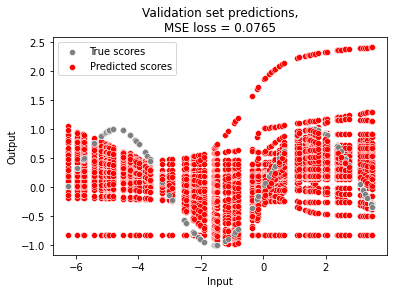

In [67]:
import mlflow
np.random.seed(42)

mlflow.set_experiment(experiment_name="MLP_automatic")

# Load dataset
X_dataset, y_dataset, _, _ = get_dataset()
X_train, y_train, X_val, y_val = preprocess_dataset(X_dataset, y_dataset)

# Constant hyperparameters
epochs = 20

# Run experiments
total_runs = len(experiment_dict.values())
for i, value in enumerate(experiment_dict.values()):
    activation, solver, hidden_layer_sizes, lr = (value["activation"], value["solver"],
                                                      value["hidden_layer_sizes"], value["lr"])
    
    with mlflow.start_run(run_name=activation):
        mlflow.log_param("Epochs", epochs)
        mlflow.log_param("Activation", activation)
        mlflow.log_param("Solver", solver)
        mlflow.log_param("Hidden_layer_sizes", hidden_layer_sizes)
        mlflow.log_param("LR", lr)
        
        # Train and evaluate
        val_preds, val_loss = train_eval_model(X_train, y_train, X_val, y_val,
                                              activation, solver, hidden_layer_sizes,
                                                lr, epochs)
        
        # Log performance as plot and MLflow parameters
        plot_performance(X_val, y_val, val_preds)
        mlflow.log_artifact("performance.pdf")
        
        performance_dict = calculate_performance(y_val, val_preds)
        mlflow.log_metric("MeanSquaredError", performance_dict["MSE"])
        mlflow.log_metric("MeanAbsoluteError", performance_dict["MAE"])
        mlflow.log_metric("Spearmanr", performance_dict["Spearmanr"])
        
        # Print performance
        print("\nRun", i+1, "of", total_runs)
        print("Val loss:", val_loss, "Activation:", activation,
              "Solver:", solver, "Hidden:", hidden_layer_sizes,
             "lr:", lr)

# 5. Load trained models from MLflow archive

1. Go to the MLflow UI, select a run, then select the model folder under "Artifacts"
2. Follow the instructions on how to predict on a Pandas DataFrame

## Tanh model

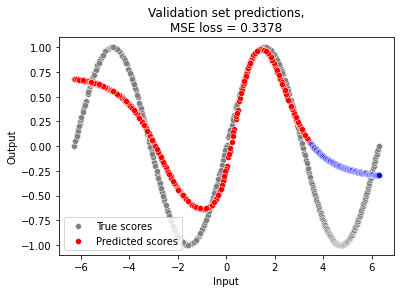

In [68]:
import mlflow
# tanh model
logged_model = 'runs:/fd9559921a81455a8f0e1b67a5739b85/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
X_test = X_test.reshape(-1, 1)

y_preds = loaded_model.predict(X_train)
plot_performance(X_train, y_train, y_preds, color="red")

y_preds = loaded_model.predict(X_test)
plot_performance(X_test, y_test, y_preds, color="blue")

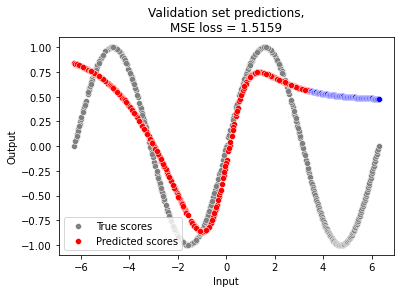

In [70]:
import mlflow
# tanh model
logged_model = 'runs:/2fae30951e974c06817550cfac99663a/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
X_test = X_test.reshape(-1, 1)

y_preds = loaded_model.predict(X_train)
plot_performance(X_train, y_train, y_preds, color="red")

y_preds = loaded_model.predict(X_test)
plot_performance(X_test, y_test, y_preds, color="blue")

## ReLU

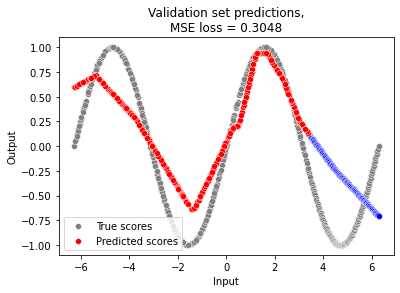

In [69]:
# relu model
logged_model = 'runs:/1a927904f0bf4048b3cd58eaedd97806/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
X_test = X_test.reshape(-1, 1)

y_preds = loaded_model.predict(X_train)
plot_performance(X_train, y_train, y_preds, color="red")

y_preds = loaded_model.predict(X_test)
plot_performance(X_test, y_test, y_preds, color="blue")

## Logistic Activation

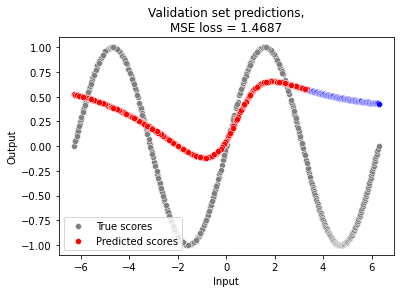

In [29]:
# Logistic
logged_model = 'runs:/32cadf9a7baa4ced95cef5d277eba34f/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
X_test = X_test.reshape(-1, 1)

y_preds = loaded_model.predict(X_train)
plot_performance(X_train, y_train, y_preds, color="red")

y_preds = loaded_model.predict(X_test)
plot_performance(X_test, y_test, y_preds, color="blue")